In [134]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.gridspec as gridspec

Parámetros del sistema

In [177]:
w_0 = 0.5 # Frecuencia natural x>0
W_0 = 7 # Frecuencia natural x<0
amort = 0.125 # constante de amortiguamiento
f_0 = 0.25 # Amplitud de la fuerza por unidad de masa
m = 1 # masa del oscilador
N = 5 # Numero de fonones
w = [1.4] # frecuencia de la fuerza externa
X_0 = 5 # Condición inicial
n = np.size(w)

In [136]:
rep = n-1 # w para la que queremos las figuras

Frecuencia natural del oscilador

In [137]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [178]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [201]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    phi = (m*w_0/(np.pi))**(0.25)*(1/math.sqrt(2**n*np.math.factorial(n)))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [202]:
x = np.linspace(-10,10,500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)

100%|██████████| 5/5 [00:00<00:00, 145.20it/s]


c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


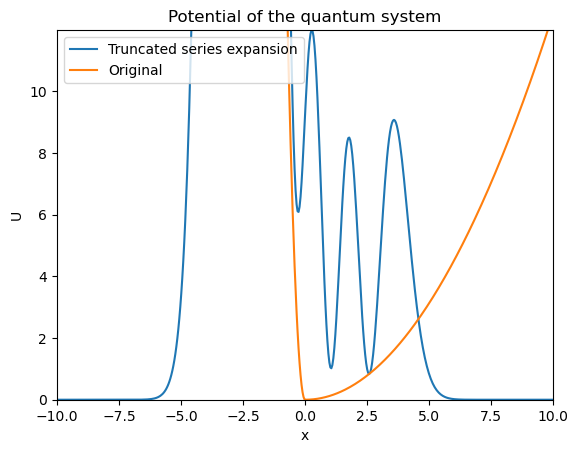

In [203]:
plt.plot(x,U_x,label='Truncated series expansion')
plt.plot(x,U(x),label='Original')
plt.xlim([np.min(x),np.max(x)])
plt.ylim([0,np.max(U_x[(np.size(U_x)//2):])])
plt.title('Potential of the quantum system')
plt.xlabel('x')
plt.ylabel('U')
plt.legend()
plt.show()

Simulación de la dinámica cuántica

In [142]:
dt = 0.1 # Paso de tiempo
tf = 100 # Tiempo de medida (se asume que t0 = 0)
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

In [143]:
def check_state(psi):
    check = np.sum(np.diagonal(psi.full())[-5:])

    if check >= 1e-2:
        return sys.exit("Warning: add more phonons")

In [144]:
# Estado inicial:
psi0 = coherent(N,X_0*math.sqrt(0.5))

x_0 = expect(position(N),psi0)/math.sqrt(w_0*m) 
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)

# Estado para comparar:
# psi02 = coherent(N,math.sqrt(0.6))

In [145]:
def H1coeff(t,args):
    return f_0*m*np.cos(args['w']*t)

In [146]:
result = []
H0 = w_0*momentum(N)**2/2+U_q
H1 = position(N)/math.sqrt(w_0*m)
x_exp = position(N)/math.sqrt(w_0*m)
p_exp = momentum(N)*math.sqrt(w_0*m)
x2_exp = position(N)**2/(w_0*m)
p2_exp = momentum(N)**2*(w_0*m)
coll = math.sqrt(2*amort*m)*destroy(N)
options = Options(store_states=True,nsteps=5000)

for i in tqdm(range(n)):
    args = {'w': w[i]}
    H = [H0,[H1,H1coeff]]
    result.append(mesolve(H, psi0, tvec, [coll], [x_exp,p_exp,x2_exp,p2_exp],options=options,args=args))
    # result2 = mesolve(H, psi02, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options)

100%|██████████| 1/1 [02:05<00:00, 125.87s/it]


Wigner function evolution

In [147]:
Wigner = []
wig_xvec = np.linspace(-6,6,100)
wig_pvec = np.linspace(-6,6,100)

for i in tqdm(range(np.size(tvec))):   
    Wigner.append(wigner(result[rep].states[i], wig_xvec, wig_pvec))

100%|██████████| 1001/1001 [00:45<00:00, 22.16it/s]


Amount of negativity

In [148]:
neg = []
#pos = []

for i in range(np.shape(Wigner)[0]):
    neg.append(100*np.sum(((Wigner[i]<0)*1)*np.abs(Wigner[i]))/np.sum(np.abs(Wigner[i])))
    #pos.append(100*np.sum(((Wigner[i]>=0)*1)*np.abs(Wigner[i]))/np.sum(np.abs(Wigner[i])))

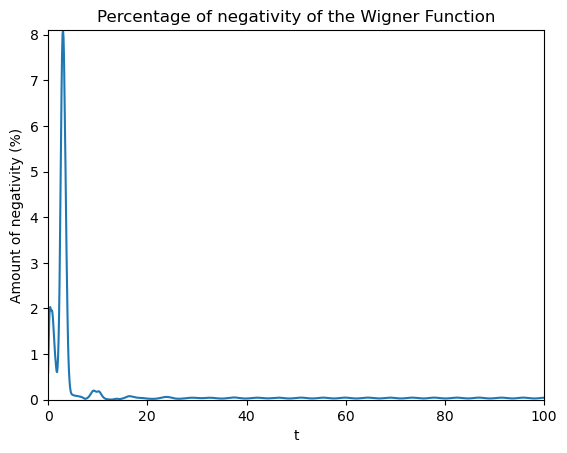

In [149]:
fig1 = plt.figure()
plt.plot(tvec,neg)
plt.xlim([0,tf])
plt.ylim([0,np.max(neg)])
plt.title('Percentage of negativity of the Wigner Function')
plt.xlabel('t')
plt.ylabel('Amount of negativity (%)')
plt.show()

Probability density

In [205]:
np.shape(np.resize(autoest(j,x,False),[np.size(x),1])*np.resize(autoest(j,x,True),[1,np.size(x)]))

(500, 500)

In [207]:
np.shape(result[rep].states[i])

(30, 30)

In [151]:
prob = []
for j in range(N):
        xx = np.resize(autoest(j,x,False),[np.size(x),1])*np.resize(autoest(j,x,True),[1,np.size(x)])
for i in tqdm(range(np.size(tvec))):
    psi_x = 0
    for j in range(N):
        psi_x = psi_x + result[rep].states[i][j]*np.resize(autoest(j,x,False),[np.size(x),1])*np.resize(autoest(j,x,True),[1,np.size(x)])
    prob.append(np.abs(psi_x)**2)

  0%|          | 0/1001 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (500,) (1,30) 

In [ ]:
print(result[rep].states[i])

Quantum object: dims = [[30], [30]], shape = (30, 30), type = oper, isherm = True
Qobj data =
[[1.11089965e-02 2.35657404e-02 3.53486105e-02 4.32930295e-02
  4.59191921e-02 4.35627706e-02 3.77264660e-02 3.02484664e-02
  2.26863498e-02 1.60416718e-02 1.07610806e-02 6.88281027e-03
  4.21484329e-03 2.47979633e-03 1.40591237e-03 7.70049918e-04
  4.08380639e-04 2.10110106e-04 1.05055053e-04 5.11265399e-05
  2.42514472e-05 1.12262388e-05 5.07725693e-06 2.24580425e-06
  9.72454287e-07 4.12602020e-07 1.71575397e-07 7.02784574e-08
  2.75020665e-08 1.26896903e-08]
 [2.35657404e-02 4.99904844e-02 7.49857266e-02 9.18383841e-02
  9.74093163e-02 9.24105914e-02 8.00299198e-02 6.41666872e-02
  4.81250154e-02 3.40295248e-02 2.28276992e-02 1.46006455e-02
  8.94103282e-03 5.26044240e-03 2.98239051e-03 1.63352256e-03
  8.66306158e-04 4.45710841e-04 2.22855421e-04 1.08455769e-04
  5.14450883e-05 2.38144487e-05 1.07704884e-05 4.76407025e-06
  2.06288706e-06 8.75261058e-07 3.63966380e-07 1.49083121e-07
  5.8

Save animations and figures

In [ ]:
def update_Wigner(num,Wigner):
    plt.cla()
    wmap = wigner_cmap(Wigner[num])
    nrm = mpl.colors.Normalize(-Wigner[num].max(), Wigner[num].max())
    plt.contourf(wig_xvec, wig_pvec, Wigner[num], 100, cmap=cm.RdBu, norm=nrm)
    plt.xlim([np.min(wig_xvec),np.max(wig_xvec)])
    plt.ylim([np.min(wig_pvec),np.max(wig_pvec)])
    plt.title('Evolution of the Wigner function (t = '+str(format(tvec[num],'.3f'))+' s)')
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('p')

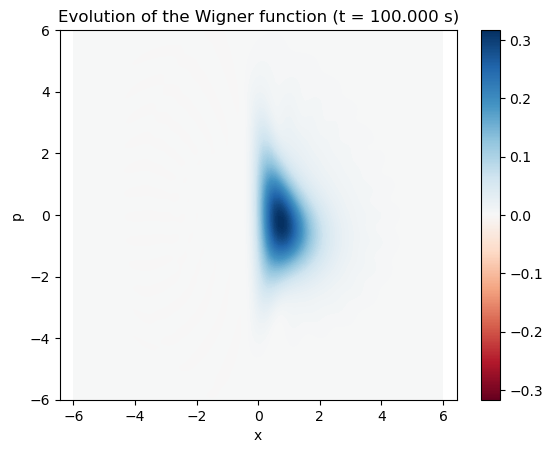

In [ ]:
imW = plt.figure()
wmap = wigner_cmap(Wigner[0])
nrm = mpl.colors.Normalize(-Wigner[0].max(), Wigner[0].max())
figW = plt.contourf(wig_xvec, wig_pvec, Wigner[0], 100, cmap=cm.RdBu, norm=nrm)
plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu))
animW = animation.FuncAnimation(imW, update_Wigner, range(np.size(tvec)), fargs = (Wigner, ), interval = 25)
animW.save('WIGNER (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).gif')
animW.save('WIGNER (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).mp4')

In [ ]:
def update_prob(num,prob):
    ax1.cla()
    ax2.cla()
    ax1.plot(x, prob[num][0], label = '$|Ψ(x)|^2$', color = 'purple')
    ax2.plot(x,U(x), alpha = 0.5, label = 'U(x)')
    ax1.set_xlim([np.min(x),np.max(x)])
    ax1.set_ylim([0,1.5])
    ax2.set_ylim([0,100])
    ax1.set_title('Evolution of probability density (t = '+str(format(tvec[num],'.3f'))+' s)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('$|Ψ(x)|^2$')
    ax2.set_ylabel('U(x)')
    ax2.legend()

IndexError: list index out of range

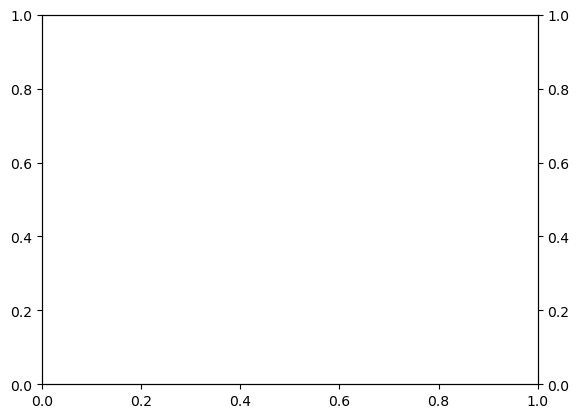

In [ ]:
imP = plt.figure()
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(x, prob[0][0], label = '$|Ψ(x)|^2$', color = 'purple')
ax2.plot(x,U(x), alpha = 0.5, label = 'U(x)')
animP = animation.FuncAnimation(imP, update_prob, range(np.size(tvec)), fargs = (prob, ), interval = 25)
animP.save('prob (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).gif')
animP.save('prob (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).mp4')

In [ ]:
fig1.savefig('Negativity (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).png')